#**Assignment: Marketing - Speech-to-text**

1. Google Cloud Platform (GCP) Speech-to-Text API enabled.
2. GCP Natural Language API enabled.
3. GCP Service Account - reused.
4. Audio file with WAV extensions created.
5. Created a bucket in GCP Storage.
6. Uploaded audio WAV file to GCP Storage bucket.


##**7. Extracting the text from audio file.**

In [1]:
!pip install google-cloud-speech

In [2]:
import os
import pprint
import csv
import pandas as pd
import datetime
from datetime import date
from google.cloud import storage
from google.cloud import speech

In [3]:
# Load your Service Account
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "sanil_fernandes_s24.json"

In [4]:
def list_blobs(bucket_name):
    """Lists all the blobs in the bucket."""
    # bucket_name = "your-bucket-name"

    storage_client = storage.Client()

    # Note: Client.list_blobs requires at least package version 1.17.0.

    # Note: The call returns a response only when the iterator is consumed.
    return storage_client.list_blobs(bucket_name)

In [5]:
def extract_audio_gcs(gcs_uri):
    """Asynchronously transcribes the audio file specified by the gcs_uri."""

    client = speech.SpeechClient()

    audio = speech.RecognitionAudio(uri=gcs_uri)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        audio_channel_count=2,
        language_code="en-US",
    )

    operation = client.long_running_recognize(config=config, audio=audio)

    print("Waiting for operation to complete...")

    return operation.result(timeout=150)

In [6]:
# Main
bucket_name = "marketing_ai_sanil"
blobs = list_blobs(bucket_name)
for blob in blobs:
    print(blob.name)

# Create audio file URI
gcs_uri = "gs://" + bucket_name + "/" + blob.name
print("\nThis is the uri: {}".format(gcs_uri))

S_F_2024.wav

This is the uri: gs://marketing_ai_sanil/S_F_2024.wav


In [7]:
# Extract text from audio file
response = extract_audio_gcs(gcs_uri=gcs_uri)
pprint.pprint(response)

# Access each response element
print("Accessing each element:")

data = []

for result in response.results:
  data.append({
        'wav_filename': blob.name,
        'transcript': result.alternatives[0].transcript,
        'confidence': result.alternatives[0].confidence,
        'transcription_date': date.today().strftime("%Y-%m-%d")
        })

pprint.pprint(data)

Waiting for operation to complete...
results {
  alternatives {
    transcript: "hi John it\'s very nice to see you"
    confidence: 0.9720942378044128
  }
  result_end_time {
    seconds: 10
    nanos: 520000000
  }
  language_code: "en-us"
}
results {
  alternatives {
    transcript: " hello Sara it\'s been a very long time"
    confidence: 0.9328583478927612
  }
  result_end_time {
    seconds: 15
    nanos: 260000000
  }
  language_code: "en-us"
}
results {
  alternatives {
    transcript: " yes it has been almost two years"
    confidence: 0.9202288389205933
  }
  result_end_time {
    seconds: 20
    nanos: 160000000
  }
  language_code: "en-us"
}
results {
  alternatives {
    transcript: " I really miss our high school and our classmates"
    confidence: 0.9457321166992188
  }
  result_end_time {
    seconds: 25
    nanos: 730000000
  }
  language_code: "en-us"
}
results {
  alternatives {
    transcript: " me to school bus so much fun do you remember when you always used to ge

In [8]:
#Saving The extracted Audio
df = pd.DataFrame(data)
df.to_csv('extracted_audio.csv', index=False)
print('Extracted audio transcript and saved to extracted_audio.csv')

Extracted audio transcript and saved to extracted_audio.csv


In [9]:
print(df.head())

   wav_filename                                         transcript  \
0  S_F_2024.wav                  hi John it's very nice to see you   
1  S_F_2024.wav              hello Sara it's been a very long time   
2  S_F_2024.wav                   yes it has been almost two years   
3  S_F_2024.wav   I really miss our high school and our classmates   
4  S_F_2024.wav   me to school bus so much fun do you remember ...   

   confidence transcription_date  
0    0.972094         2024-06-03  
1    0.932858         2024-06-03  
2    0.920229         2024-06-03  
3    0.945732         2024-06-03  
4    0.980124         2024-06-03  


##**8. Running Sentiment analysis on the extracted audio text**

In [10]:
# Install the google-cloud-language package
!pip install google-cloud-language

# Imports the Google Cloud client library
from google.cloud import language_v1

# Instantiates a client
client = language_v1.LanguageServiceClient()

In [11]:
# Load the existing CSV file
df_extract = pd.read_csv('/content/extracted_audio.csv')
df_extract['transcript'] = df_extract['transcript'].astype(str)

In [12]:
# Detects the sentiment of the text
def analyze_sentiment(text):
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(request={"document": document}).document_sentiment
    return sentiment.score, sentiment.magnitude

In [13]:
# Add sentiment and magnitude to each sentence
df_extract['sentence_number'] = None
df_extract['sentiment'] = None
df_extract['magnitude'] = None

for index, row in df_extract.iterrows():
    text = row['transcript']
    sentiment_score, sentiment_magnitude = analyze_sentiment(text)
    df_extract.iloc[index, df_extract.columns.get_loc('sentence_number')] = index + 1
    df_extract.at[index, 'sentiment'] = sentiment_score
    df_extract.at[index, 'magnitude'] = sentiment_magnitude

In [14]:
# Updating the Dataframe
df_extract_updated = ['wav_filename', 'sentence_number', 'transcript', 'confidence', 'transcription_date', 'sentiment', 'magnitude']
df_extract = df_extract[df_extract_updated]

In [15]:
# Display the updated DataFrame
print(df_extract.head())

   wav_filename sentence_number  \
0  S_F_2024.wav               1   
1  S_F_2024.wav               2   
2  S_F_2024.wav               3   
3  S_F_2024.wav               4   
4  S_F_2024.wav               5   

                                          transcript  confidence  \
0                  hi John it's very nice to see you    0.972094   
1              hello Sara it's been a very long time    0.932858   
2                   yes it has been almost two years    0.920229   
3   I really miss our high school and our classmates    0.945732   
4   me to school bus so much fun do you remember ...    0.980124   

  transcription_date sentiment magnitude  
0         2024-06-03       0.9       0.9  
1         2024-06-03      -0.1       0.1  
2         2024-06-03       0.0       0.0  
3         2024-06-03       0.6       0.6  
4         2024-06-03       0.7       0.7  


In [16]:
# Save the updated DataFrame
df_extract.to_csv('audio_with_sentiment.csv', index=False)

In [17]:
# Compute Sentiment, Magnitude and confidence averages
average_sentiment = df_extract['sentiment'].mean()
average_magnitude = df_extract['magnitude'].mean()
average_confidence = df_extract['confidence'].mean()

In [18]:
print(f"Average Sentiment: {average_sentiment:.2f}")
print(f"Average Magnitude: {average_magnitude:.2f}")
print(f"Average Confidence: {average_confidence:.2f}")

Average Sentiment: 0.16
Average Magnitude: 0.43
Average Confidence: 0.94


##**9. Storing each speech-extracted record in a No-SQL database.**

In [19]:
!pip install --upgrade firebase-admin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
  Attempting uninstall: firebase-admin
    Found existing installation: firebase-admin 5.3.0
    Uninstalling firebase-admin-5.3.0:
      Successfully uninstalled firebase-admin-5.3.0


In [20]:
!pip show google-cloud-firestore

Name: google-cloud-firestore
Version: 2.11.1
Summary: Google Cloud Firestore API client library
Home-page: https://github.com/googleapis/python-firestore
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: google-api-core, google-cloud-core, proto-plus, protobuf
Required-by: firebase-admin


In [21]:
!pip install google-cloud-firestore

In [22]:
import os
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [23]:
# Use a service account.
cred = credentials.Certificate('sanil_fernandes_s24.json')
app = firebase_admin.initialize_app(cred)
db = firestore.client()

In [24]:
#Add Data
def store_data_in_firestore(df_extract, collection_name="Sanil's_speech_analysis"):
    counter = 0
    # Use a write batch
    batch = db.batch()

    for index, row in df_extract.iterrows():
        data_dict = row.to_dict()

        doc_ref = db.collection(collection_name).document(f"transcript_{counter}")
        batch.set(doc_ref, data_dict)

        # Increment counter for next document
        counter += 1

    try:
        batch.commit()
        print(f'Data uploaded successfully!')
    except Exception as e:
        print(f'Error uploading data: {e}')

In [25]:
# Store the Data into Firebase Database
store_data_in_firestore(df_extract)

Data uploaded successfully!


**Database screenshot**

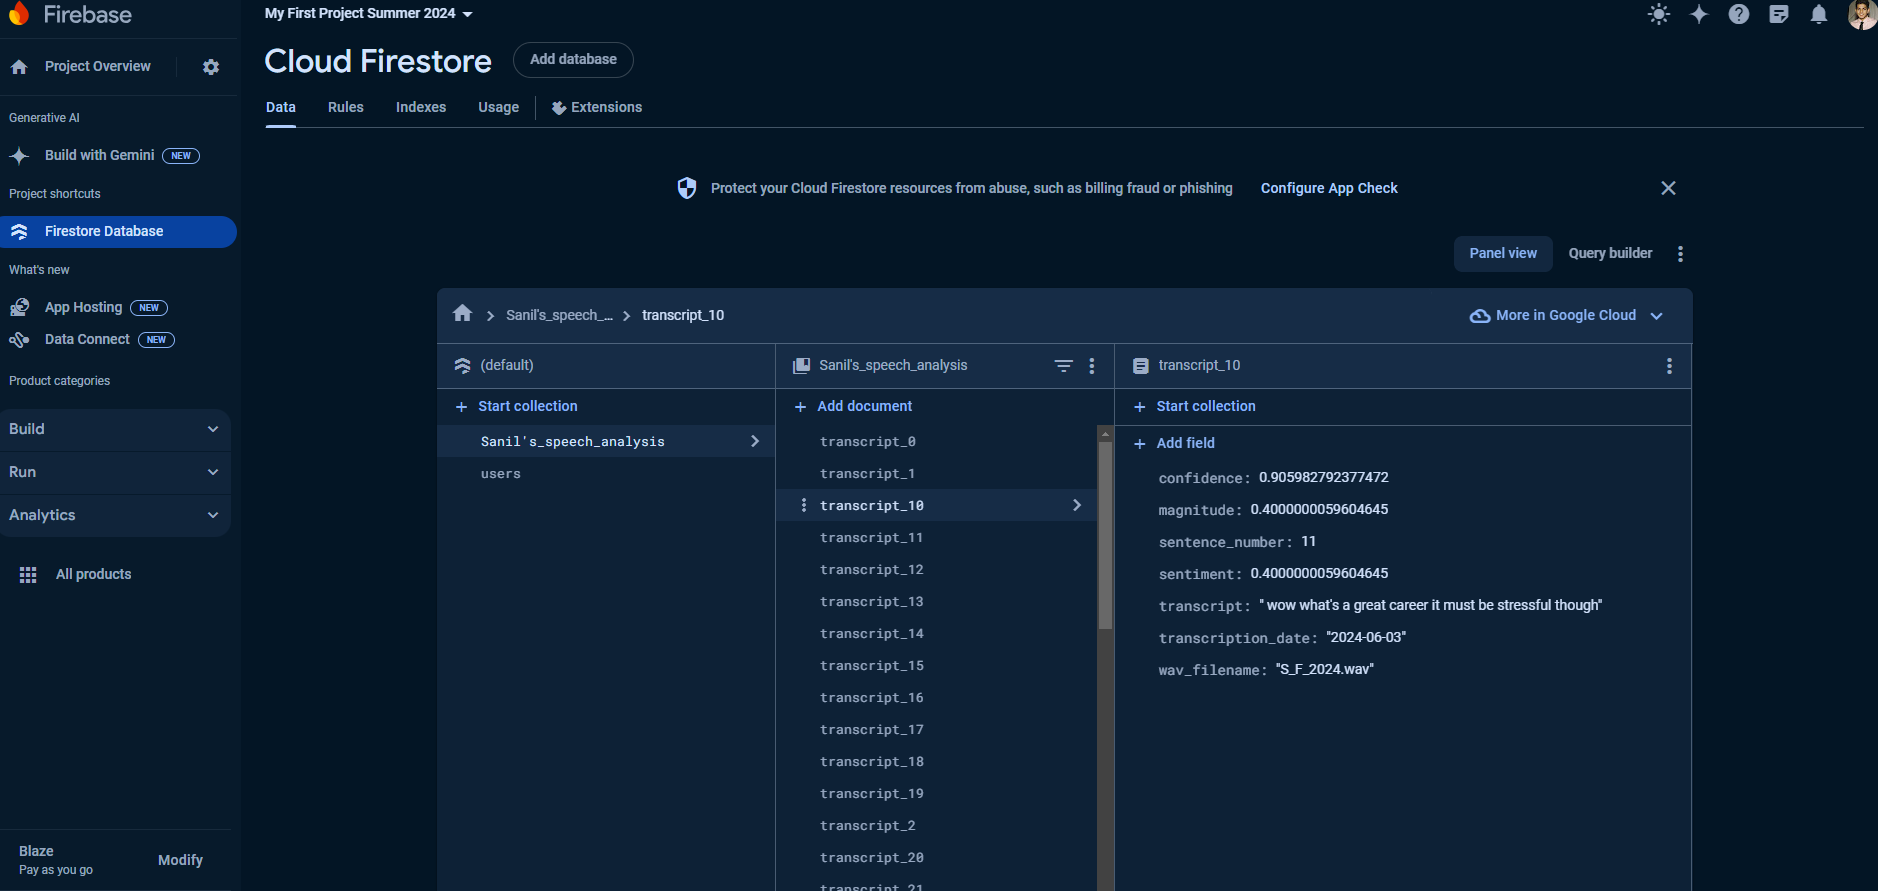

##**10. Visualizations and Findings.**

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Load the CSV file
df_audio = pd.read_csv('audio_with_sentiment.csv')

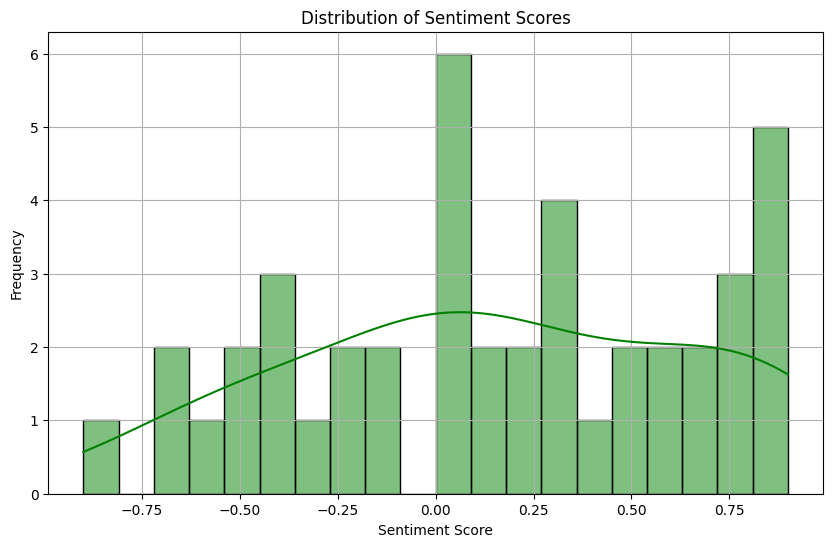

In [28]:
# Visualization 1: Sentiment Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_audio['sentiment'], bins=20, kde=True, color='green')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

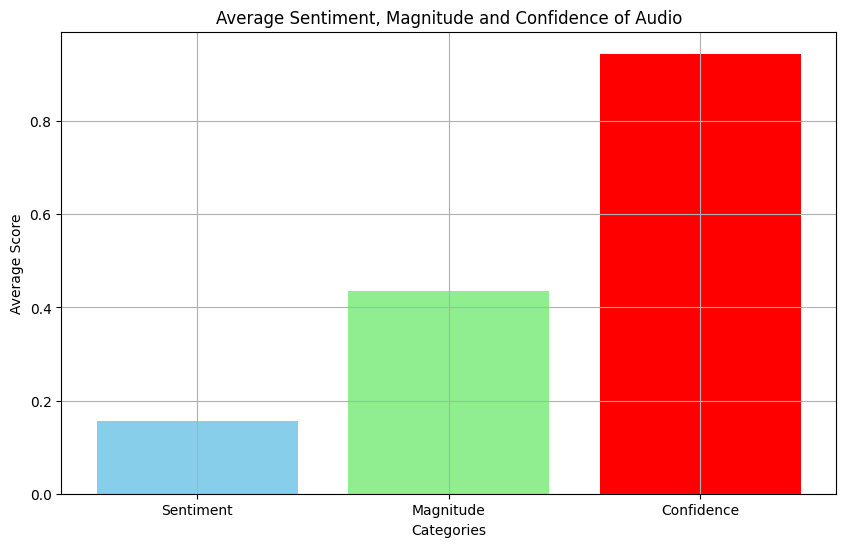

In [29]:
# Visualization 2: Average Sentiment and Magnitude of Extracted Audio
labels = ['Sentiment', 'Magnitude', 'Confidence']
values = [average_sentiment, average_magnitude, average_confidence]
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['skyblue', 'lightgreen' , 'red'])
plt.title('Average Sentiment, Magnitude and Confidence of Audio')
plt.xlabel('Categories')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

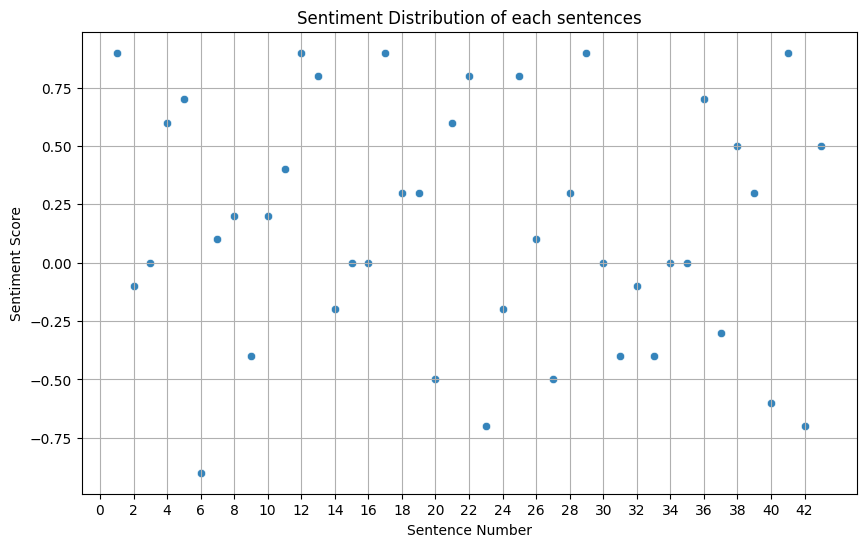

In [30]:
# Visualization 3: Sentiment of each sentences
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentence_number', y='sentiment', data=df_audio, alpha=0.9)
plt.title('Sentiment Distribution of each sentences')
plt.xticks(range(0, len(df_audio), 2))
plt.xlabel('Sentence Number')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

##**Visualizations and Findings**

**Visualization 1**
The graph reveals a diverse range of opinions in the data set. Sentiment scores span the entire spectrum, from very positive to very negative, indicating significant variation in sentiment across the analyzed audio. Also substantial portion of the audio scores around a neutral sentiment, suggesting factual statements or mixed emotions.

**Visualization 2**
Average Sentiment indicates mix of positive, negative, and neutral sentiments, showing a positive score of 0.16.
Average Magnitude is 0.43, indicating moderate sentiment intensity.
The sentiment analysis results are reliable, with an average confidence of 0.94.

**Visualization 3**
The scatter plot illustrates the variability in sentiment for individual sentences, highlighting a mix of positive, negative, and neutral sentiments throughout the audio. This suggests that the audio content is dynamic in terms of emotional expression, without a consistent trend towards positive or negative sentiment over time.

**Average Sentiment, Magnitude and Confidence**

*   Average Sentiment: 0.16
*   Average Magnitude: 0.43
*   Average Confidence: 0.94


**Recommendations**

To enhance the emotional impact, consider structuring the content to balance positive, negative, and neutral sentiments in a way that aligns with the intended message. Use the insights from the sentiment analysis to tailor the sentences for better audience engagement, focusing on maintaining a dynamic and varied emotional tone.

**Conclusion**

The audio exhibits dynamic emotional expression, characterized by a mix of positive, negative, and neutral sentiment throughout. This finding suggests the absence of a dominant emotional trend.






